# 0. Import dependencies

In [1]:
import pandas as pd
import re
import matplotlib.pyplot as plt
import numpy as np

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold, GridSearchCV
from sklearn.neural_network import MLPRegressor

# 1. Process data

In [2]:
# Import data
raw_df = pd.read_excel('Data/Data_Train.xlsx')
raw_df.head(5)

,Airline,Date_of_Journey,Source,Destination,Route,Dep_Time,Arrival_Time,Duration,Total_Stops,Additional_Info,Price
0,IndiGo,24/03/2019,Banglore,New Delhi,BLR → DEL,22:20,01:10 22 Mar,2h 50m,non-stop,No info,3897
1,Air India,1/05/2019,Kolkata,Banglore,CCU → IXR → BBI → BLR,05:50,13:15,7h 25m,2 stops,No info,7662
2,Jet Airways,9/06/2019,Delhi,Cochin,DEL → LKO → BOM → COK,09:25,04:25 10 Jun,19h,2 stops,No info,13882
3,IndiGo,12/05/2019,Kolkata,Banglore,CCU → NAG → BLR,18:05,23:30,5h 25m,1 stop,No info,6218
4,IndiGo,01/03/2019,Banglore,New Delhi,BLR → NAG → DEL,16:50,21:35,4h 45m,1 stop,No info,13302


In [3]:
# Check data types in the dataframe
raw_df.dtypes

Airline            object
Date_of_Journey    object
Source             object
Destination        object
Route              object
Dep_Time           object
Arrival_Time       object
Duration           object
Total_Stops        object
Additional_Info    object
Price               int64
dtype: object

In [4]:
# Is there any na rows?
raw_df.count()

Airline            10683
Date_of_Journey    10683
Source             10683
Destination        10683
Route              10682
Dep_Time           10683
Arrival_Time       10683
Duration           10683
Total_Stops        10682
Additional_Info    10683
Price              10683
dtype: int64

There are nas in 'Route' and 'Total_Stops'

In [5]:
# Inspect for na rows
raw_df[raw_df.isna().any(axis=1)]

,Airline,Date_of_Journey,Source,Destination,Route,Dep_Time,Arrival_Time,Duration,Total_Stops,Additional_Info,Price
9039,Air India,6/05/2019,Delhi,Cochin,NaN,09:45,09:25 07 May,23h 40m,NaN,No info,7480


In [6]:
# Check for abnormal values in each column
for col in raw_df.columns:
    print('\nColumn: {0}'.format(col))
    print(raw_df[col].value_counts())


Column: Airline
Jet Airways                          3849
IndiGo                               2053
Air India                            1752
Multiple carriers                    1196
SpiceJet                              818
Vistara                               479
Air Asia                              319
GoAir                                 194
Multiple carriers Premium economy      13
Jet Airways Business                    6
Vistara Premium economy                 3
Trujet                                  1
Name: Airline, dtype: int64

Column: Date_of_Journey
18/05/2019    504
6/06/2019     503
21/05/2019    497
9/06/2019     495
12/06/2019    493
9/05/2019     484
21/03/2019    423
15/05/2019    405
27/05/2019    382
27/06/2019    355
24/06/2019    351
1/06/2019     342
3/06/2019     333
15/06/2019    328
24/03/2019    323
6/03/2019     308
27/03/2019    299
24/05/2019    286
6/05/2019     282
1/05/2019     277
12/05/2019    259
1/04/2019     257
3/03/2019     218
9/03/2019   

In 'Additional_Info', there are 2 separate counts for 'No info' ("No info" and "No Info"), normalize them into 'No info'.

In [7]:
# Inspect for null rows.
raw_df[raw_df.isnull().any(axis=1)]

,Airline,Date_of_Journey,Source,Destination,Route,Dep_Time,Arrival_Time,Duration,Total_Stops,Additional_Info,Price
9039,Air India,6/05/2019,Delhi,Cochin,NaN,09:45,09:25 07 May,23h 40m,NaN,No info,7480


# 2. Clean data

In [8]:
# Get rid of the na rows
na_rows_indexes = raw_df[raw_df.isna().any(axis=1)].index
raw_df.drop(index=na_rows_indexes, inplace=True)
len(raw_df)

10682

In [9]:
# Normalize 'No info' in 'Additional_Info' column
raw_df.replace('No Info', 'No info', inplace=True)
raw_df[raw_df['Additional_Info'] == 'No Info']

,Airline,Date_of_Journey,Source,Destination,Route,Dep_Time,Arrival_Time,Duration,Total_Stops,Additional_Info,Price


In [10]:
raw_df.to_csv('Data/Data_After_Normalization.csv', index=False)

# 3. Select features

Features to be extracted:
- Departure time in night/day. (Boolean: 1 for night, 0 for day)
- Flight duration.
- Number of flights (number of stops + 1).
- Price.

In [11]:
def one_hot_df(df, cols):
    one_hotted_cols = pd.get_dummies(df[cols])
    result = df.join(one_hotted_cols)
    return result

In [12]:
def get_season_from_date(date):
    _, month, _ = date.split('/')
    seasons = ['Spring', 'Summer', 'Fall', 'Winter']
    return seasons[(int(month) - 1) // 3]

In [13]:
def get_night_from_time(time):
    hour = int(time.split(':')[0])
    return hour >= 18 or hour <= 5

In [14]:
def get_flight_duration(str_duration):
    hour = re.findall(r'([0-9]+)[hH]', str_duration)
    minute = re.findall(r'([0-9]+)[mM]', str_duration)
    
    hour = int(hour[0]) if len(hour) > 0 else 0
    minute = int(minute[0]) if len(minute) > 0 else 0

    return hour * 60 + minute

In [15]:
def get_number_of_flights(stops):
    num_stops = stops.split()[0]
    if num_stops.isnumeric():
        return int(num_stops) + 1
    else:
        return 1

In [16]:
def transform_raw_to_featured_data(raw_df):
    raw_df['Night'] = raw_df['Dep_Time'].apply(get_night_from_time)
    raw_df['Duration'] = raw_df['Duration'].apply(get_flight_duration)
    raw_df['Number_of_Flights'] = raw_df['Total_Stops'].apply(get_number_of_flights)

    
    one_hot_columns = ['Airline', 'Additional_Info', 'Date_of_Journey', 'Dep_Time', 'Total_Stops', 'Source', 'Destination', 'Route', 'Arrival_Time']
    feature_df = raw_df.drop(columns=one_hot_columns)
    return feature_df

In [17]:
# Transform the raw data into trainable data
feature_df = raw_df.copy()
feature_df = transform_raw_to_featured_data(feature_df)
feature_df.head()

,Duration,Price,Night,Number_of_Flights
0,170,3897,True,1
1,445,7662,True,3
2,1140,13882,False,3
3,325,6218,True,2
4,285,13302,False,2


In [18]:
# Save that trainable data
feature_df.to_csv('Data/Trainable_Dataset.csv', index=False)

# 4. Handle outliers

In this section, I only handle outliers based on a common knowledge of flight duration, which is really unlikely to be under 15 minutes.


There is a boxplot below for Duration, Price, and Number_of_Flights. That is for tuning the model later on.

In [19]:
feature_df = pd.read_csv('Data/Trainable_Dataset.csv')
len(feature_df)

10682

In [20]:
# Check for abnormally low flight duration
feature_df[feature_df['Duration'] < 15]

,Duration,Price,Night,Number_of_Flights
6474,5,17327,False,3


I don't know about this: 3 flights, within 5 minutes. It doesn't sound right at all so I'm removing it.

In [21]:
strange_df_index = feature_df[feature_df['Duration'] < 15].index
feature_df.drop(index=strange_df_index, inplace=True)
len(feature_df)

10681

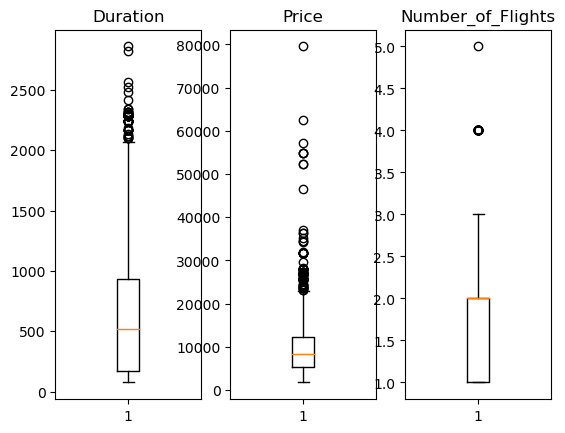

<Figure size 2000x1000 with 0 Axes>

In [22]:
# Box plot for better understanding of data for later model tuning
fig, (ax1, ax2, ax3) = plt.subplots(1, 3)
data1 = feature_df['Duration'].values
data2 = feature_df['Price'].values
data3 = feature_df['Number_of_Flights'].values
fig = plt.figure(figsize =(20, 10))

# Creating plot
ax1.boxplot(data1)
ax1.set_title('Duration')
ax2.boxplot(data2)
ax2.set_title('Price')
ax3.boxplot(data3)
ax3.set_title('Number_of_Flights')

# show plot
plt.show()

The Number_of_Flights outliers can be ignore. But the Price and Duration can use a bit of clipping later.

In [23]:
# Save the dataset again
feature_df.to_csv('Data/Trainable_Dataset.csv', index=False)

# 5. Use machine learning algorithms and Cross validation

In this section, I'm using GridSearchCV of the sklearn library for inspection on multiple simple machine learning models, combining with cross validation in the pipeline.

The pipeline is going to be:
- Cross validation split.
- Standard or Min-max scaling of data.
- Linear regression or Decision tree.

The metric for these algorithms is MSE (mean square error). Let's do the Linear Regression model first for a baseline.

In [24]:
# Splitting the features and target in the dataset.
np.random.seed(123)
train_df = pd.read_csv('Data/Trainable_Dataset.csv')
X_train = train_df.drop(columns='Price')
y_train = train_df['Price']

In [25]:
pipe = Pipeline([('scaler', StandardScaler()), ('model', LinearRegression())])

params_dict = {'scaler': [StandardScaler(), MinMaxScaler()],
                        'model': [LinearRegression()]}

grid = GridSearchCV(estimator=pipe, 
                                   param_grid=params_dict,
                                   scoring=('neg_mean_squared_error'), 
                                   refit='neg_mean_squared_error',
                                   cv=5, verbose=2)

In [26]:
grid.fit(X_train, y_train)
df_grid = pd.DataFrame(grid.cv_results_)
df_grid.to_csv('Result/GSCV_results.csv')

Fitting 5 folds for each of 2 candidates, totalling 10 fits
[CV] END ..model=LinearRegression(), scaler=StandardScaler(); total time=   0.0s
[CV] END ..model=LinearRegression(), scaler=StandardScaler(); total time=   0.0s
[CV] END ..model=LinearRegression(), scaler=StandardScaler(); total time=   0.0s
[CV] END ..model=LinearRegression(), scaler=StandardScaler(); total time=   0.0s
[CV] END ..model=LinearRegression(), scaler=StandardScaler(); total time=   0.0s
[CV] END ....model=LinearRegression(), scaler=MinMaxScaler(); total time=   0.0s
[CV] END ....model=LinearRegression(), scaler=MinMaxScaler(); total time=   0.0s
[CV] END ....model=LinearRegression(), scaler=MinMaxScaler(); total time=   0.0s
[CV] END ....model=LinearRegression(), scaler=MinMaxScaler(); total time=   0.0s
[CV] END ....model=LinearRegression(), scaler=MinMaxScaler(); total time=   0.0s


In [27]:
df_grid.sort_values(by='rank_test_score').head(5)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_model,param_scaler,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.012723,0.015442,0.002001,0.000633,LinearRegression(),StandardScaler(),"{'model': LinearRegression(), 'scaler': Standa...",-1.406185e+07,-1.395618e+07,-1.331966e+07,-1.213032e+07,-1.326774e+07,-1.334715e+07,688394.270786,1
1,0.005040,0.000634,0.001787,0.000395,LinearRegression(),MinMaxScaler(),"{'model': LinearRegression(), 'scaler': MinMax...",-1.406185e+07,-1.395618e+07,-1.331966e+07,-1.213032e+07,-1.326774e+07,-1.334715e+07,688394.270786,1


And we start off with 13 millions MSE score using the following pipeline:
- Standard scaler.
- Linear Regression.
    

# 6. Tune model

## 6.1. How's the model? Underfitting or overfitting?

In [28]:
# Use KFold to find out the average MSE of the model

kf = KFold(n_splits=10,random_state=42,shuffle=True)

train_MSEs = []
val_MSEs = []
for train_index, test_index in kf.split(X_train):

    data_train = X_train.iloc[train_index]
    target_train = y_train.iloc[train_index]

    data_val = X_train.iloc[test_index]
    target_val = y_train.iloc[test_index]

    pipe = Pipeline([('scaler', StandardScaler()), 
                              ('model', LinearRegression())])
    pipe.fit(data_train, target_train)

    val_preds = pipe.predict(data_val)
    val_MSE = mean_squared_error(target_val, val_preds)

    train_preds = pipe.predict(data_train)
    train_MSE = mean_squared_error(target_train, train_preds)

    print('Train MSE:', train_MSE)
    print('Val MSE:', val_MSE)

    train_MSEs.append(train_MSE)
    val_MSEs.append(val_MSE)
    
average_MSE = np.mean(val_MSEs)
average_MSE

Train MSE: 13270826.36205509
Val MSE: 13919720.36703599
Train MSE: 13415333.982448617
Val MSE: 12618238.908661047
Train MSE: 13355599.741365157
Val MSE: 13158900.41383505
Train MSE: 13643484.044180097
Val MSE: 10566880.275209446
Train MSE: 13570073.296803378
Val MSE: 11232700.062683748
Train MSE: 13078592.528582282
Val MSE: 15653054.00706036
Train MSE: 12980814.376529928
Val MSE: 16534522.175690325
Train MSE: 13213400.68384742
Val MSE: 14434823.233320717
Train MSE: 13304671.31984026
Val MSE: 13613611.190286947
Train MSE: 13515690.79783997
Val MSE: 11714663.33592512


13344711.396970876

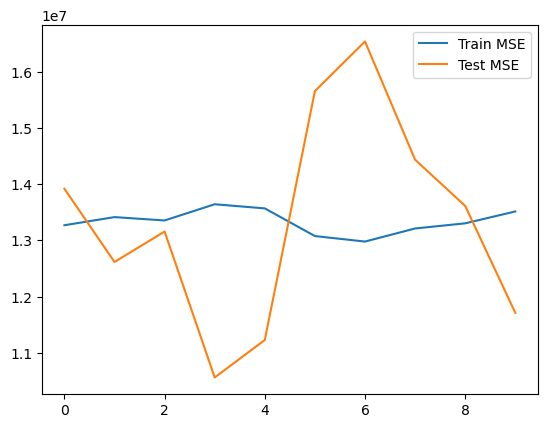

In [29]:
plt.plot(train_MSEs, label='Train MSE')
plt.plot(val_MSEs, label ='Test MSE')
plt.legend()
plt.show()

Here, we can see how the MSE for train and validation set are quite close from each other, but over 10 millions MSE suggest that each prediction differs from the actual cost at about over 3500 dollars, which is not desirable.

Now, we can either put a more complex algorithm for this model or we modify our dataset a little bit.

I'm going to mess with the data.

## 6.2. Handle noisy data

Based on the image below, we know that there are some outliers in the Duration and Price data. We have 2 ways to handle them:
- Clipping them at the maximum of the box plot.
- Completely remove them from our dataset.


<img src="boxplot.png" alt="this image" />

### 6.2.1 Clipping the data

In [30]:
def set_upper_lower_fence_for_df(df, col):
    q1 = df[col].quantile(0.25)
    q3 = df[col].quantile(0.75)
    iqr = q3 - q1

    lower_fence = q1 - (1.5 * iqr)
    upper_fence = q3 + (1.5 * iqr)
    
    df.loc[df[col] > upper_fence, col] = upper_fence
    df.loc[df[col] < lower_fence, col] = lower_fence
    
    return df

In [31]:
feature_df = pd.read_csv('Data/Trainable_Dataset.csv')
feature_df = set_upper_lower_fence_for_df(feature_df, 'Duration')
feature_df = set_upper_lower_fence_for_df(feature_df, 'Price')

feature_df.to_csv('Data/Clipped_Trainable_Dataset.csv', index=False)

In [32]:
# Test the model again with our new dataset.

train_df = pd.read_csv('Data/Clipped_Trainable_Dataset.csv')
X_train = train_df.drop(columns='Price')
y_train = train_df['Price']

kf = KFold(n_splits=10,random_state=123,shuffle=True)

train_MSEs = []
val_MSEs = []
for train_index, test_index in kf.split(X_train):

    data_train = X_train.iloc[train_index]
    target_train = y_train.iloc[train_index]

    data_val = X_train.iloc[test_index]
    target_val = y_train.iloc[test_index]

    pipe = Pipeline([('scaler', StandardScaler()), 
                              ('model', LinearRegression())])
    pipe.fit(data_train, target_train)

    val_preds = pipe.predict(data_val)
    val_MSE = mean_squared_error(target_val, val_preds)

    train_preds = pipe.predict(data_train)
    train_MSE = mean_squared_error(target_train, train_preds)

    print('Train MSE:', train_MSE)
    print('Val MSE:', val_MSE)

    train_MSEs.append(train_MSE)
    val_MSEs.append(val_MSE)
    
average_MSE = np.mean(val_MSEs)
average_MSE

Train MSE: 10282118.24299948
Val MSE: 10800416.747942522
Train MSE: 10399302.377767183
Val MSE: 9740102.317908684
Train MSE: 10304924.47193087
Val MSE: 10588434.968283137
Train MSE: 10371741.364129307
Val MSE: 9985672.894679235
Train MSE: 10477265.744723596
Val MSE: 9037945.822932152
Train MSE: 10331746.595534017
Val MSE: 10346737.936749311
Train MSE: 10446153.722719539
Val MSE: 9318245.889866637
Train MSE: 10327711.807650983
Val MSE: 10381860.305901565
Train MSE: 10117060.254425634
Val MSE: 12285744.286367284
Train MSE: 10266219.732395563
Val MSE: 10936200.993382333


10342136.216401286

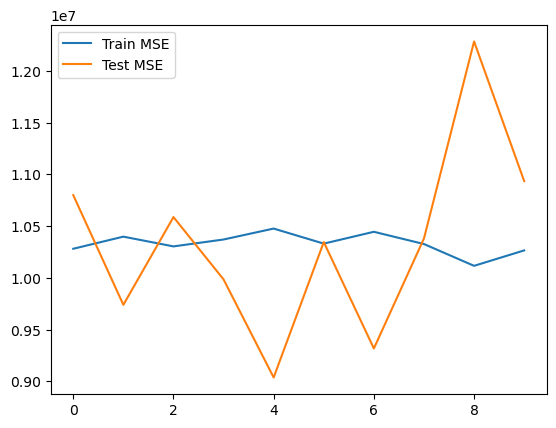

In [33]:
plt.plot(train_MSEs, label='Train MSE')
plt.plot(val_MSEs, label ='Test MSE')
plt.legend()
plt.show()

The MSE is now 10 millions, better than what we got at 13 millions.

### 6.2.2 Remove the outliers

In [34]:
def remove_outliers_from_df(df, col):
    q1 = df[col].quantile(0.25)
    q3 = df[col].quantile(0.75)
    iqr = q3 - q1

    lower_fence = q1 - (1.5 * iqr)
    upper_fence = q3 + (1.5 * iqr)
    
    indexes = df[df[col] > upper_fence].index
    df.drop(index=indexes, inplace=True)
    
    indexes = df[df[col] < lower_fence].index
    df.drop(index=indexes, inplace=True)

    return df

In [35]:
feature_df = pd.read_csv('Data/Trainable_Dataset.csv')
feature_df = remove_outliers_from_df(feature_df, 'Duration')
feature_df = remove_outliers_from_df(feature_df, 'Price')

feature_df.to_csv('Data/Outlier_Dropped_Trainable_Dataset.csv', index=False)
len(feature_df) # 10515/10681 --> 98.44% data left

10515

In [36]:
# Test the model again with our new dataset.

train_df = pd.read_csv('Data/Outlier_Dropped_Trainable_Dataset.csv')
X_train = train_df.drop(columns='Price')
y_train = train_df['Price']

kf = KFold(n_splits=10,random_state=123,shuffle=True)

train_MSEs = []
val_MSEs = []
for train_index, test_index in kf.split(X_train):

    data_train = X_train.iloc[train_index]
    target_train = y_train.iloc[train_index]

    data_val = X_train.iloc[test_index]
    target_val = y_train.iloc[test_index]

    pipe = Pipeline([('scaler', StandardScaler()), 
                              ('model', LinearRegression())])
    pipe.fit(data_train, target_train)

    val_preds = pipe.predict(data_val)
    val_MSE = mean_squared_error(target_val, val_preds)

    train_preds = pipe.predict(data_train)
    train_MSE = mean_squared_error(target_train, train_preds)

    print('Train MSE:', train_MSE)
    print('Val MSE:', val_MSE)

    train_MSEs.append(train_MSE)
    val_MSEs.append(val_MSE)
    
average_MSE = np.mean(val_MSEs)
average_MSE

Train MSE: 8816926.716584845
Val MSE: 8925080.293670472
Train MSE: 8767389.39362767
Val MSE: 9371622.48745528
Train MSE: 8900212.317857
Val MSE: 8179390.946179892
Train MSE: 8730919.692711018
Val MSE: 9702687.018926598
Train MSE: 8823268.604704423
Val MSE: 8868985.287362672
Train MSE: 8877815.859488875
Val MSE: 8386158.092547312
Train MSE: 8833427.127717534
Val MSE: 8777113.659001866
Train MSE: 8902791.729424253
Val MSE: 8152789.086337481
Train MSE: 8769507.468004197
Val MSE: 9352839.18906739
Train MSE: 8852369.577717382
Val MSE: 8608679.062841743


8832534.51233907

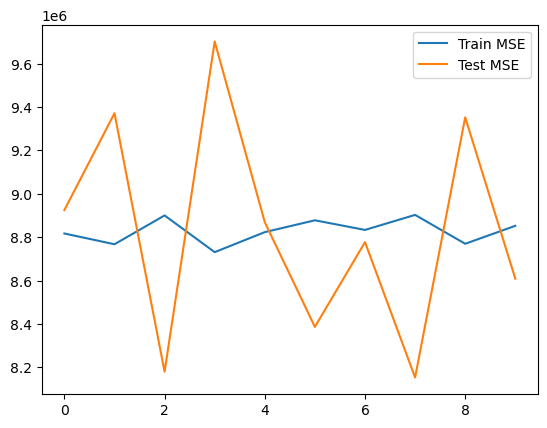

In [37]:
plt.plot(train_MSEs, label='Train MSE')
plt.plot(val_MSEs, label ='Test MSE')
plt.legend()
plt.show()

The MSE is now 8.8 millions, better than what we got at 10 millions.

## 6.3. Try a more complex model

Uptil now, I've tried to do some work on the data, now it's time to focus more on the model.

I'm going to upgrade our model, from a decision tree regressor to a random forest regressor.

In [39]:
# Splitting the features and target in the dataset.
np.random.seed(123)
train_df = pd.read_csv('Data/Outlier_Dropped_Trainable_Dataset.csv')
X_train = train_df.drop(columns='Price')
y_train = train_df['Price']

In [40]:
pipe = Pipeline([('scaler', StandardScaler()),
                          ('model', MLPRegressor(max_iter=10000, early_stopping=True))])

params_dict = {'scaler': [StandardScaler(), MinMaxScaler()],
                         'model': [MLPRegressor(max_iter=10000, early_stopping=True)],
                         'model__hidden_layer_sizes': [10, 20, 30,
                                                                         (10, 5), (20, 10), (30, 15),
                                                                         (10, 5, 3), (20, 10, 5), (30, 15, 5)],
                         'model__n_iter_no_change': [10, 20, 30]}

grid = GridSearchCV(estimator=pipe, 
                                   param_grid=params_dict,
                                   scoring=('neg_mean_squared_error'), 
                                   refit='neg_mean_squared_error',
                                   cv=5, verbose=3)

In [41]:
grid.fit(X_train, y_train)
df_grid = pd.DataFrame(grid.cv_results_)
df_grid.to_csv('MLP_Regressor_GSCV.csv')

Fitting 5 folds for each of 54 candidates, totalling 270 fits
[CV 1/5] END model=MLPRegressor(early_stopping=True, max_iter=10000), model__hidden_layer_sizes=10, model__n_iter_no_change=10, scaler=StandardScaler();, score=-8902340.965 total time=   9.8s
[CV 2/5] END model=MLPRegressor(early_stopping=True, max_iter=10000), model__hidden_layer_sizes=10, model__n_iter_no_change=10, scaler=StandardScaler();, score=-9049501.027 total time=   9.3s
[CV 3/5] END model=MLPRegressor(early_stopping=True, max_iter=10000), model__hidden_layer_sizes=10, model__n_iter_no_change=10, scaler=StandardScaler();, score=-9030236.024 total time=  14.9s
[CV 4/5] END model=MLPRegressor(early_stopping=True, max_iter=10000), model__hidden_layer_sizes=10, model__n_iter_no_change=10, scaler=StandardScaler();, score=-8915428.276 total time=  10.1s
[CV 5/5] END model=MLPRegressor(early_stopping=True, max_iter=10000), model__hidden_layer_sizes=10, model__n_iter_no_change=10, scaler=StandardScaler();, score=-8766602.6

[CV 4/5] END model=MLPRegressor(early_stopping=True, max_iter=10000), model__hidden_layer_sizes=20, model__n_iter_no_change=20, scaler=StandardScaler();, score=-8913919.429 total time=  11.7s
[CV 5/5] END model=MLPRegressor(early_stopping=True, max_iter=10000), model__hidden_layer_sizes=20, model__n_iter_no_change=20, scaler=StandardScaler();, score=-8806930.113 total time=  12.8s
[CV 1/5] END model=MLPRegressor(early_stopping=True, max_iter=10000), model__hidden_layer_sizes=20, model__n_iter_no_change=20, scaler=MinMaxScaler();, score=-9150411.727 total time=  11.9s
[CV 2/5] END model=MLPRegressor(early_stopping=True, max_iter=10000), model__hidden_layer_sizes=20, model__n_iter_no_change=20, scaler=MinMaxScaler();, score=-9092432.990 total time=  11.8s
[CV 3/5] END model=MLPRegressor(early_stopping=True, max_iter=10000), model__hidden_layer_sizes=20, model__n_iter_no_change=20, scaler=MinMaxScaler();, score=-9271972.744 total time=  11.9s
[CV 4/5] END model=MLPRegressor(early_stopping

[CV 2/5] END model=MLPRegressor(early_stopping=True, max_iter=10000), model__hidden_layer_sizes=30, model__n_iter_no_change=30, scaler=MinMaxScaler();, score=-9072191.017 total time=  10.1s
[CV 3/5] END model=MLPRegressor(early_stopping=True, max_iter=10000), model__hidden_layer_sizes=30, model__n_iter_no_change=30, scaler=MinMaxScaler();, score=-9011121.668 total time=  12.7s
[CV 4/5] END model=MLPRegressor(early_stopping=True, max_iter=10000), model__hidden_layer_sizes=30, model__n_iter_no_change=30, scaler=MinMaxScaler();, score=-9096735.378 total time=  10.0s
[CV 5/5] END model=MLPRegressor(early_stopping=True, max_iter=10000), model__hidden_layer_sizes=30, model__n_iter_no_change=30, scaler=MinMaxScaler();, score=-8871939.599 total time=  11.0s
[CV 1/5] END model=MLPRegressor(early_stopping=True, max_iter=10000), model__hidden_layer_sizes=(10, 5), model__n_iter_no_change=10, scaler=StandardScaler();, score=-8902464.044 total time=   5.2s
[CV 2/5] END model=MLPRegressor(early_stopp

[CV 4/5] END model=MLPRegressor(early_stopping=True, max_iter=10000), model__hidden_layer_sizes=(20, 10), model__n_iter_no_change=10, scaler=MinMaxScaler();, score=-8852837.374 total time=   4.5s
[CV 5/5] END model=MLPRegressor(early_stopping=True, max_iter=10000), model__hidden_layer_sizes=(20, 10), model__n_iter_no_change=10, scaler=MinMaxScaler();, score=-8827622.112 total time=   4.0s
[CV 1/5] END model=MLPRegressor(early_stopping=True, max_iter=10000), model__hidden_layer_sizes=(20, 10), model__n_iter_no_change=20, scaler=StandardScaler();, score=-8869828.356 total time=   3.7s
[CV 2/5] END model=MLPRegressor(early_stopping=True, max_iter=10000), model__hidden_layer_sizes=(20, 10), model__n_iter_no_change=20, scaler=StandardScaler();, score=-7927811.932 total time=   8.7s
[CV 3/5] END model=MLPRegressor(early_stopping=True, max_iter=10000), model__hidden_layer_sizes=(20, 10), model__n_iter_no_change=20, scaler=StandardScaler();, score=-8228075.790 total time=   9.2s
[CV 4/5] END m

[CV 1/5] END model=MLPRegressor(early_stopping=True, max_iter=10000), model__hidden_layer_sizes=(30, 15), model__n_iter_no_change=30, scaler=StandardScaler();, score=-8009661.623 total time=  15.6s
[CV 2/5] END model=MLPRegressor(early_stopping=True, max_iter=10000), model__hidden_layer_sizes=(30, 15), model__n_iter_no_change=30, scaler=StandardScaler();, score=-8811560.188 total time=   4.5s
[CV 3/5] END model=MLPRegressor(early_stopping=True, max_iter=10000), model__hidden_layer_sizes=(30, 15), model__n_iter_no_change=30, scaler=StandardScaler();, score=-8952239.151 total time=   6.4s
[CV 4/5] END model=MLPRegressor(early_stopping=True, max_iter=10000), model__hidden_layer_sizes=(30, 15), model__n_iter_no_change=30, scaler=StandardScaler();, score=-7926836.785 total time=  15.1s
[CV 5/5] END model=MLPRegressor(early_stopping=True, max_iter=10000), model__hidden_layer_sizes=(30, 15), model__n_iter_no_change=30, scaler=StandardScaler();, score=-8683782.476 total time=   5.4s
[CV 1/5] E

[CV 3/5] END model=MLPRegressor(early_stopping=True, max_iter=10000), model__hidden_layer_sizes=(20, 10, 5), model__n_iter_no_change=10, scaler=StandardScaler();, score=-8602940.840 total time=   4.9s
[CV 4/5] END model=MLPRegressor(early_stopping=True, max_iter=10000), model__hidden_layer_sizes=(20, 10, 5), model__n_iter_no_change=10, scaler=StandardScaler();, score=-8726932.590 total time=   2.8s
[CV 5/5] END model=MLPRegressor(early_stopping=True, max_iter=10000), model__hidden_layer_sizes=(20, 10, 5), model__n_iter_no_change=10, scaler=StandardScaler();, score=-8687937.643 total time=   2.8s
[CV 1/5] END model=MLPRegressor(early_stopping=True, max_iter=10000), model__hidden_layer_sizes=(20, 10, 5), model__n_iter_no_change=10, scaler=MinMaxScaler();, score=-8960508.346 total time=   3.7s
[CV 2/5] END model=MLPRegressor(early_stopping=True, max_iter=10000), model__hidden_layer_sizes=(20, 10, 5), model__n_iter_no_change=10, scaler=MinMaxScaler();, score=-8835666.189 total time=   7.1s

[CV 4/5] END model=MLPRegressor(early_stopping=True, max_iter=10000), model__hidden_layer_sizes=(30, 15, 5), model__n_iter_no_change=20, scaler=StandardScaler();, score=-8719240.916 total time=   4.1s
[CV 5/5] END model=MLPRegressor(early_stopping=True, max_iter=10000), model__hidden_layer_sizes=(30, 15, 5), model__n_iter_no_change=20, scaler=StandardScaler();, score=-7869146.457 total time=  11.2s
[CV 1/5] END model=MLPRegressor(early_stopping=True, max_iter=10000), model__hidden_layer_sizes=(30, 15, 5), model__n_iter_no_change=20, scaler=MinMaxScaler();, score=-8888222.918 total time=   6.5s
[CV 2/5] END model=MLPRegressor(early_stopping=True, max_iter=10000), model__hidden_layer_sizes=(30, 15, 5), model__n_iter_no_change=20, scaler=MinMaxScaler();, score=-7975809.183 total time=  15.0s
[CV 3/5] END model=MLPRegressor(early_stopping=True, max_iter=10000), model__hidden_layer_sizes=(30, 15, 5), model__n_iter_no_change=20, scaler=MinMaxScaler();, score=-8948121.203 total time=   5.0s
[

In [42]:
df_grid.sort_values(by='rank_test_score').head(5)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_model,param_model__hidden_layer_sizes,param_model__n_iter_no_change,param_scaler,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
28,14.849869,8.587331,0.002400,0.000490,"MLPRegressor(early_stopping=True, hidden_layer...","(20, 10)",30,StandardScaler(),"{'model': MLPRegressor(early_stopping=True, hi...",-8.201238e+06,-8.785467e+06,-8.201693e+06,-7.879257e+06,-7.923188e+06,-8.198169e+06,323190.433272,1
22,11.554851,5.214708,0.002201,0.000400,"MLPRegressor(early_stopping=True, hidden_layer...","(10, 5)",30,StandardScaler(),"{'model': MLPRegressor(early_stopping=True, hi...",-8.136161e+06,-8.014854e+06,-8.140728e+06,-8.264316e+06,-8.736008e+06,-8.258413e+06,251494.598586,2
44,9.363213,3.460460,0.002999,0.000633,"MLPRegressor(early_stopping=True, hidden_layer...","(20, 10, 5)",20,StandardScaler(),"{'model': MLPRegressor(early_stopping=True, hi...",-8.551546e+06,-8.795187e+06,-8.214596e+06,-7.947480e+06,-7.821407e+06,-8.266043e+06,364234.953599,3
46,6.664033,3.476007,0.003372,0.000427,"MLPRegressor(early_stopping=True, hidden_layer...","(20, 10, 5)",30,StandardScaler(),"{'model': MLPRegressor(early_stopping=True, hi...",-7.862506e+06,-8.784881e+06,-8.947576e+06,-8.741371e+06,-7.831522e+06,-8.433571e+06,483929.696533,4
30,5.566491,2.891318,0.002609,0.000496,"MLPRegressor(early_stopping=True, hidden_layer...","(30, 15)",10,StandardScaler(),"{'model': MLPRegressor(early_stopping=True, hi...",-8.878378e+06,-7.915670e+06,-8.942276e+06,-7.947732e+06,-8.675885e+06,-8.471988e+06,449940.253284,5


Removing outliers and using a more complex model is not that effective, the MSE is now around 8.1 millions.

Although, we now know that standard scaler goes quite well with the dataset and we should need about 3 * 20 + 20 * 10 + 10 = 270 weight parameters and 20 + 10 + 1 = 31 bias parameters, which is 301 parameters in total for this task.

I'm testing on a tree regressor below for further experimenting on the suitable models for this dataset.

In [43]:
pipe = Pipeline([('scaler', StandardScaler()),
                          ('model', DecisionTreeRegressor())])

params_dict = {'scaler': [StandardScaler(), MinMaxScaler()],
                         'model': [DecisionTreeRegressor(criterion='squared_error', splitter='best')],
                         'model__max_depth': [5, 10, 15, 20, 25, None],
                         'model__min_samples_leaf': [1000, 500, 200, 100, 50]}

grid = GridSearchCV(estimator=pipe, 
                                   param_grid=params_dict,
                                   scoring=('neg_mean_squared_error'), 
                                   refit='neg_mean_squared_error',
                                   cv=5, verbose=3)

In [44]:
grid.fit(X_train, y_train)
df_grid = pd.DataFrame(grid.cv_results_)
df_grid.to_csv('Result/Decision_Tree_GSCV.csv')

Fitting 5 folds for each of 60 candidates, totalling 300 fits
[CV 1/5] END model=DecisionTreeRegressor(), model__max_depth=5, model__min_samples_leaf=1000, scaler=StandardScaler();, score=-7672791.295 total time=   0.0s
[CV 2/5] END model=DecisionTreeRegressor(), model__max_depth=5, model__min_samples_leaf=1000, scaler=StandardScaler();, score=-7673133.170 total time=   0.0s
[CV 3/5] END model=DecisionTreeRegressor(), model__max_depth=5, model__min_samples_leaf=1000, scaler=StandardScaler();, score=-7991382.412 total time=   0.0s
[CV 4/5] END model=DecisionTreeRegressor(), model__max_depth=5, model__min_samples_leaf=1000, scaler=StandardScaler();, score=-7897321.682 total time=   0.0s
[CV 5/5] END model=DecisionTreeRegressor(), model__max_depth=5, model__min_samples_leaf=1000, scaler=StandardScaler();, score=-7719531.439 total time=   0.0s
[CV 1/5] END model=DecisionTreeRegressor(), model__max_depth=5, model__min_samples_leaf=1000, scaler=MinMaxScaler();, score=-7672791.295 total time=

[CV 2/5] END model=DecisionTreeRegressor(), model__max_depth=10, model__min_samples_leaf=200, scaler=StandardScaler();, score=-7491509.713 total time=   0.0s
[CV 3/5] END model=DecisionTreeRegressor(), model__max_depth=10, model__min_samples_leaf=200, scaler=StandardScaler();, score=-7764921.758 total time=   0.0s
[CV 4/5] END model=DecisionTreeRegressor(), model__max_depth=10, model__min_samples_leaf=200, scaler=StandardScaler();, score=-7591033.206 total time=   0.0s
[CV 5/5] END model=DecisionTreeRegressor(), model__max_depth=10, model__min_samples_leaf=200, scaler=StandardScaler();, score=-7446091.682 total time=   0.0s
[CV 1/5] END model=DecisionTreeRegressor(), model__max_depth=10, model__min_samples_leaf=200, scaler=MinMaxScaler();, score=-7471453.748 total time=   0.0s
[CV 2/5] END model=DecisionTreeRegressor(), model__max_depth=10, model__min_samples_leaf=200, scaler=MinMaxScaler();, score=-7491509.713 total time=   0.0s
[CV 3/5] END model=DecisionTreeRegressor(), model__max_d

[CV 1/5] END model=DecisionTreeRegressor(), model__max_depth=15, model__min_samples_leaf=50, scaler=StandardScaler();, score=-7186415.570 total time=   0.0s
[CV 2/5] END model=DecisionTreeRegressor(), model__max_depth=15, model__min_samples_leaf=50, scaler=StandardScaler();, score=-7215179.387 total time=   0.0s
[CV 3/5] END model=DecisionTreeRegressor(), model__max_depth=15, model__min_samples_leaf=50, scaler=StandardScaler();, score=-7417493.145 total time=   0.0s
[CV 4/5] END model=DecisionTreeRegressor(), model__max_depth=15, model__min_samples_leaf=50, scaler=StandardScaler();, score=-7102605.911 total time=   0.0s
[CV 5/5] END model=DecisionTreeRegressor(), model__max_depth=15, model__min_samples_leaf=50, scaler=StandardScaler();, score=-7204768.896 total time=   0.0s
[CV 1/5] END model=DecisionTreeRegressor(), model__max_depth=15, model__min_samples_leaf=50, scaler=MinMaxScaler();, score=-7186415.570 total time=   0.0s
[CV 2/5] END model=DecisionTreeRegressor(), model__max_depth

[CV 2/5] END model=DecisionTreeRegressor(), model__max_depth=25, model__min_samples_leaf=500, scaler=StandardScaler();, score=-7557092.149 total time=   0.0s
[CV 3/5] END model=DecisionTreeRegressor(), model__max_depth=25, model__min_samples_leaf=500, scaler=StandardScaler();, score=-7860091.997 total time=   0.0s
[CV 4/5] END model=DecisionTreeRegressor(), model__max_depth=25, model__min_samples_leaf=500, scaler=StandardScaler();, score=-7716678.486 total time=   0.0s
[CV 5/5] END model=DecisionTreeRegressor(), model__max_depth=25, model__min_samples_leaf=500, scaler=StandardScaler();, score=-7518377.178 total time=   0.0s
[CV 1/5] END model=DecisionTreeRegressor(), model__max_depth=25, model__min_samples_leaf=500, scaler=MinMaxScaler();, score=-7531729.447 total time=   0.0s
[CV 2/5] END model=DecisionTreeRegressor(), model__max_depth=25, model__min_samples_leaf=500, scaler=MinMaxScaler();, score=-7557092.149 total time=   0.0s
[CV 3/5] END model=DecisionTreeRegressor(), model__max_d

[CV 2/5] END model=DecisionTreeRegressor(), model__max_depth=None, model__min_samples_leaf=200, scaler=MinMaxScaler();, score=-7485556.950 total time=   0.0s
[CV 3/5] END model=DecisionTreeRegressor(), model__max_depth=None, model__min_samples_leaf=200, scaler=MinMaxScaler();, score=-7764921.758 total time=   0.0s
[CV 4/5] END model=DecisionTreeRegressor(), model__max_depth=None, model__min_samples_leaf=200, scaler=MinMaxScaler();, score=-7591033.206 total time=   0.0s
[CV 5/5] END model=DecisionTreeRegressor(), model__max_depth=None, model__min_samples_leaf=200, scaler=MinMaxScaler();, score=-7446091.682 total time=   0.0s
[CV 1/5] END model=DecisionTreeRegressor(), model__max_depth=None, model__min_samples_leaf=100, scaler=StandardScaler();, score=-7294231.091 total time=   0.0s
[CV 2/5] END model=DecisionTreeRegressor(), model__max_depth=None, model__min_samples_leaf=100, scaler=StandardScaler();, score=-7444136.275 total time=   0.0s
[CV 3/5] END model=DecisionTreeRegressor(), mode

In [45]:
df_grid.sort_values(by='rank_test_score').head(5)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_model,param_model__max_depth,param_model__min_samples_leaf,param_scaler,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
48,0.007298,0.000369,0.002002,0.000003,"DecisionTreeRegressor(max_depth=20, min_sample...",25,50,StandardScaler(),"{'model': DecisionTreeRegressor(max_depth=20, ...",-7.139036e+06,-7.212448e+06,-7.417493e+06,-7.102606e+06,-7.204769e+06,-7.215270e+06,109102.936221,1
38,0.006718,0.000387,0.002030,0.000061,"DecisionTreeRegressor(max_depth=20, min_sample...",20,50,StandardScaler(),"{'model': DecisionTreeRegressor(max_depth=20, ...",-7.139036e+06,-7.212448e+06,-7.417493e+06,-7.102606e+06,-7.204769e+06,-7.215270e+06,109102.936221,1
58,0.007213,0.000427,0.002027,0.000043,"DecisionTreeRegressor(max_depth=20, min_sample...",None,50,StandardScaler(),"{'model': DecisionTreeRegressor(max_depth=20, ...",-7.139036e+06,-7.212448e+06,-7.417493e+06,-7.102606e+06,-7.204769e+06,-7.215270e+06,109102.936221,1
59,0.007205,0.000394,0.002002,0.000006,"DecisionTreeRegressor(max_depth=20, min_sample...",None,50,MinMaxScaler(),"{'model': DecisionTreeRegressor(max_depth=20, ...",-7.139036e+06,-7.212448e+06,-7.431626e+06,-7.102606e+06,-7.204769e+06,-7.218097e+06,114361.724205,4
49,0.007050,0.000065,0.001601,0.000490,"DecisionTreeRegressor(max_depth=20, min_sample...",25,50,MinMaxScaler(),"{'model': DecisionTreeRegressor(max_depth=20, ...",-7.139036e+06,-7.212448e+06,-7.431626e+06,-7.102606e+06,-7.204769e+06,-7.218097e+06,114361.724205,4


The tree regressor did somewhat good on the dataset. Reducing MSE to 7.1 million. Especially with the moderate depth at 25 and minimum samples per leaf at 50.